# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

In [2]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from elements.abstracts import AbstractModulator
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from elements.simple import AdjustSize
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
import torch
import numpy
import timm
import pandas
from copy import deepcopy
from cluster import train, confusion, execute, epochs

In [3]:
FontLibrary.Fonts.PlotTitle.FontSize = 16

FontLibrary.Fonts.DescriptionLeft.FontSize = 12
FontLibrary.Fonts.DescriptionLeft.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionLeft.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionBottom.FontSize = 10
FontLibrary.Fonts.DescriptionBottom.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionBottom.FontStyle = 'italic'

FontLibrary.Fonts.DescriptionTop.FontSize = 10
FontLibrary.Fonts.DescriptionTop.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionTop.FontStyle = 'italic'

FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FontLibrary.Fonts.AxisX.FontSize = 8
FontLibrary.Fonts.AxisY.FontSize = 8
FigureWidthHeight = (6.69291, 10.1181-1.0)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA A100-SXM4-80GB


# Определение параметров модели

In [5]:
def resnet18(classes:int=10):
    return timm.create_model('resnet18', pretrained=False, in_chans=1, num_classes=classes).to(device)

In [6]:
def combined_loss(cross_entropy_to_mse_proportion:float=1.0):
    def loss_function(outputs, targets):
        CELoss = torch.nn.functional.cross_entropy(outputs, targets)
        MSELoss = torch.nn.functional.mse_loss(torch.nn.functional.softmax(outputs, dim=1), torch.nn.functional.one_hot(targets, num_classes=10).float())
        loss = cross_entropy_to_mse_proportion*CELoss + (1.0-cross_entropy_to_mse_proportion)*MSELoss
        return loss
    return loss_function

In [7]:
# Предпочтительные параметры
size = 30.0E-6
near_N = 400 #2004 #1336
near_length = 6.0E-3
wavelength = 500.0E-9
detectors_amount = 24
masks_amount = 10
distance = 0.05

# Параметры обучения
batch_size = 32
learning_rate = 0.009854
loss_function_proportion = 0.609798
optimizer_type_name = 'RMSprop'
optimizer_types_list = {'Adam':torch.optim.Adam, 'SGD':torch.optim.SGD, 'RMSprop':torch.optim.RMSprop, 'Adagrad':torch.optim.Adagrad}

# Параметры когерентности
spatial_coherence = 100.0E-6
time_coherence = 10.0E-9
time_relaxation = 1.0E-6
mean_samples = 50

# Вычисляемые параметры
pixels = upper_integer(near_length/size)
length = pixels * size
cppp = int(near_N * size / length)
N = upper_integer(length*cppp / size) 
detector_size = length / 60

print(f"Длинна волны:                             {engineering(wavelength, 'м')}")
print(f"Количество вычислительных пикселей:       {N}")
print(f"Количество пикселей маски:                {pixels}")
print(f"Размер оптических элементов:              {engineering(length, 'м')}")
print(f"Размер пикселя маски:                     {engineering(length/pixels, 'м')}")
print(f"Расстояние между слоями:                  {engineering(distance, 'м')}")

print(f"Временная когерентность:                  {engineering(time_coherence, 'с')}")
print(f"Время релаксации:                         {engineering(time_relaxation, 'c')}")
print(f"Пространственная когерентность:           {engineering(spatial_coherence, 'м')}")
print(f"Количество усреднений:                    {mean_samples}")

print(f"Размер детекторов:                        {engineering(detector_size, 'м')}")
print(f"Количество детекторов:                    {detectors_amount} на {detectors_amount}")

print(f"Пропорция CE к MSE лосс:                  {loss_function_proportion}")
print(f"Размер батча:                             {batch_size}")
print(f"Тип оптимизатора:                         {optimizer_type_name}")

Длинна волны:                             500.0 нм
Количество вычислительных пикселей:       400
Количество пикселей маски:                200
Размер оптических элементов:              6.0 мм
Размер пикселя маски:                     30.0 мкм
Расстояние между слоями:                  50.0 мм
Временная когерентность:                  10.0 нс
Время релаксации:                         1.0 мкc
Пространственная когерентность:           100.0 мкм
Количество усреднений:                    50
Размер детекторов:                        100.0 мкм
Количество детекторов:                    24 на 24
Пропорция CE к MSE лосс:                  0.609798
Размер батча:                             32
Тип оптимизатора:                         RMSprop


# Диапазон расстояний

In [8]:
# Настройка диапазона
distance_left_multiplier = 0.1
distance_right_multiplier = 1.0

slices = 20
distance_samples = 3
distance_array = numpy.linspace(distance*distance_left_multiplier, distance*distance_right_multiplier, distance_samples)

In [9]:
different_distance_propagations = []
# Вычисления
initial = torch.zeros((1, 1, N, N), device=device, dtype=torch.complex64)
p0 = N//2 - upper_integer(N*size/(length*2))
p1 = p0 + upper_integer(N*size/length)
if p1 <= p0: p1 = p0+1 
initial[0,0,p0:p1,p0:p1] = 1.0
print(p0, p1)

with torch.no_grad():
    incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length)
    incoherent_encoder, incoherent_decoder = incoherent.pair()
    incoherent_encoder, incoherent_decoder = incoherent_encoder.to(device), incoherent_decoder.to(device)
    for max_distance in tqdm(distance_array):
        result = torch.zeros((slices, N), dtype=torch.float32)
        for i, dist in enumerate(numpy.linspace(0, max_distance, slices)):
            propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, dist).to(device)
            result = incoherent_decoder.forward(propagation.forward(incoherent_encoder.forward(initial))).squeeze().abs().cpu()
        different_distance_propagations.append((max_distance, result))

199 201


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.28s/it]


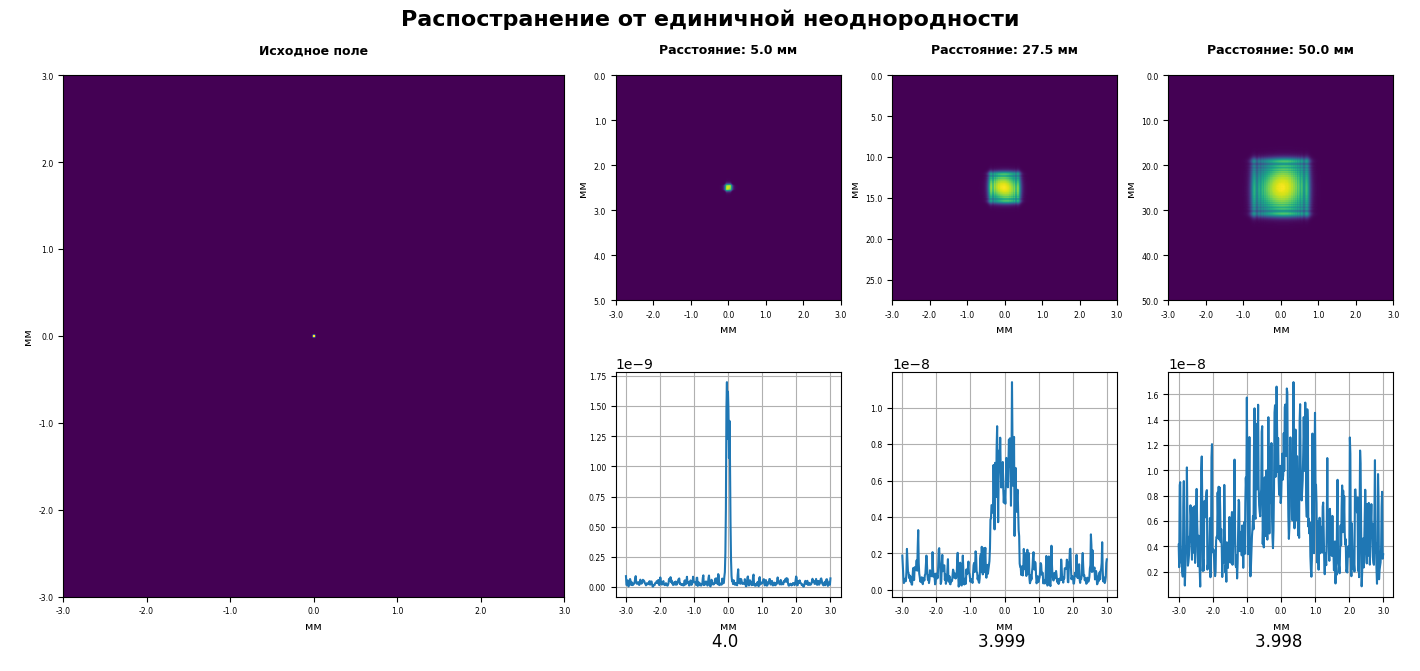

In [10]:
plot = TiledPlot(14, 14)
plot.FontLibrary = FontLibrary
plot.title('Распостранение от единичной неоднородности')

formatter_xy, unit_xy = engineering.separatedformatter(length/2, 'м')

axes = plot.axes.add((0,0),(1,1))
axes.imshow(initial[0][0].abs().cpu(), aspect='auto', extent=[-length/2,+length/2]*2)
axes.xaxis.set_major_formatter(formatter_xy)
axes.yaxis.set_major_formatter(formatter_xy)
plot.graph.label.x(unit_xy)
plot.graph.label.y(unit_xy)

plot.description.column.top('Исходное поле',0,1)

for col, (dist, data) in enumerate(different_distance_propagations, 2):
    formatter_z, unit_z = engineering.separatedformatter(dist, 'м')
    plot.description.column.top(f"Расстояние: {engineering(dist,'м', 2)}", col)
    
    axes = plot.axes.add(col, 0)
    axes.imshow(torch.log10(data+0.001), aspect='auto', extent=[-length/2,+length/2,dist,0])
    axes.xaxis.set_major_formatter(formatter_xy)
    axes.yaxis.set_major_formatter(formatter_z)
    plot.graph.label.x(unit_xy)
    plot.graph.label.y(unit_z)

    axes = plot.axes.add(col,1)
    axes.grid(True)
    axes.plot(numpy.linspace(-length/2,+length/2,N), data[-1])
    plot.graph.description(scientific(torch.sum(data).item()))
    axes.xaxis.set_major_formatter(formatter_xy)
    plot.graph.label.x(unit_xy)

plot.show()

# Инициализация моделей

In [11]:
# Модуль некогерентности
incoherent = Incoherent(spatial_coherence, time_coherence, time_relaxation, mean_samples, N, length)
incoherent_encoder, incoherent_decoder = incoherent.pair()
incoherent_encoder, incoherent_decoder = incoherent_encoder.to(device), incoherent_decoder.to(device)

# Модули детекторов
spectral_filter = Window(centers=wavelength, sizes=300.0E-9)
detectors_filter = Gaussian((detector_size, detector_size), (0,0))
detectors_incoherent = MatrixDetectors(N, length, wavelength, detectors_amount, detectors_filter, spectral_filter).to(device)
detectors_coherent = deepcopy(detectors_incoherent)

# Электронные модели
electronic_incoherent = resnet18()
electronic_coherent = deepcopy(electronic_incoherent)

# Оптические модели
adjuster = AdjustSize(N, N)
propagation = FurrierPropagation(N, length, wavelength, 1.0, 0.0, distance, 0.4)
phase_modulators = [PhaseModulator(N, length, pixels) for i in range(masks_amount)]
amplitude_modulators = [AmplitudeModulator(N, length, pixels) for i in range(masks_amount)]
elements = [phase_modulators[0], amplitude_modulators[0]]
for phase_modulator, amplitude_modulator in zip(phase_modulators[1:], amplitude_modulators[1:]):
    elements.append(propagation)
    elements.append(phase_modulator)
    elements.append(amplitude_modulator)
elements.append(propagation)
optical_incoherent = CompositeModel(adjuster, incoherent_encoder, *deepcopy(elements), incoherent_decoder).to(device)
optical_coherent = CompositeModel(adjuster, *deepcopy(elements)).to(device)

# Гибридные модели
hybrid_model_incoherent = HybridModel(optical_incoherent, detectors_incoherent, electronic_incoherent).to(device)
hybrid_model_coherent = HybridModel(optical_coherent, detectors_coherent, electronic_coherent).to(device)

# Распределённые модели
model_incoherent = hybrid_model_incoherent
model_coherent = hybrid_model_coherent

# Набор данных
dataset = Dataset('CIFAR10', batch_size, None, None, torch.complex64, threads=1, preload=10)
dataset.load.train()
dataset.load.test()

# Тип оптимизатора и лосс-функция
loss_function = combined_loss(loss_function_proportion)
optimizer_type = optimizer_types_list[optimizer_type_name]

In [12]:
model_incoherent._optical_model._elements

(AdjustSize(),
 IncoherentEncoder(
   (_generator): GaussianNormalizer(
     (_generator): FourierMask()
   )
 ),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 PhaseModulator(),
 AmplitudeModulator(),
 FurrierPropagation(),
 IncoherentDecoder())

In [13]:
image, _ = next(iter(dataset.train))
image = image[0:2]
image = image.to(device)
print(image.shape)
image = model_incoherent._optical_model.forward(image)
print(image.shape)
image = model_incoherent._detectors.forward(image)
print(image.shape)
image = model_incoherent._electronic_model.forward(image)
print(image.shape)
torch.cuda.empty_cache()

torch.Size([2, 1, 32, 32])
torch.Size([2, 1, 400, 400])
torch.Size([2, 1, 24, 24])
torch.Size([2, 10])


# Обучение модели

In [14]:
models_history, loss_histories, confusion_matrices_history = [], [], []
mh, lh, cmh = epochs(20, 10, model_incoherent, dataset, torch.nn.CrossEntropyLoss(), optimizer_type, lr=0.0003)
models_history += mh
loss_histories += lh
confusion_matrices_history += cmh

Training main thread PID is: 1830056
Training thread#0 PID is: 1830256
AdjustSize
IncoherentEncoder
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
IncoherentDecoder
MatrixDetectors
ResNet
Training thread#1 PID is: 1830339
Training thread#2 PID is: 1830538
Training thread#3 PID is: 1830738
Training thread#4 PID is: 1830939
Training thread#5 PID is: 1831140
Training thread#6 PID is: 1831339
Training thread#7 PID is: 1831539
100%|█████████████████████████████████████████| 196/196 [02:31<00:00,  1.30it/s]
Accuracy i

In [15]:
mh, lh, cmh = epochs(20, 10, models_history[-1], dataset, torch.nn.CrossEntropyLoss(), optimizer_type, lr=0.00003)
models_history += mh
loss_histories += lh
confusion_matrices_history += cmh

Training main thread PID is: 1888299
Training thread#0 PID is: 1888501
AdjustSize
IncoherentEncoder
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
IncoherentDecoder
MatrixDetectors
ResNet
Training thread#1 PID is: 1888572
Training thread#2 PID is: 1888772
Training thread#3 PID is: 1888981
Training thread#4 PID is: 1889180
Training thread#5 PID is: 1889379
Training thread#6 PID is: 1889590
Training thread#7 PID is: 1889790
100%|█████████████████████████████████████████| 196/196 [02:31<00:00,  1.29it/s]
Accuracy i

In [16]:
mh, lh, cmh = epochs(20, 10, models_history[-1], dataset, torch.nn.CrossEntropyLoss(), optimizer_type, lr=0.000003)
models_history += mh
loss_histories += lh
confusion_matrices_history += cmh

Training main thread PID is: 1945724
Training thread#0 PID is: 1945925
AdjustSize
IncoherentEncoder
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
IncoherentDecoder
MatrixDetectors
ResNet
Training thread#1 PID is: 1945997
Training thread#2 PID is: 1946196
Training thread#3 PID is: 1946395
Training thread#4 PID is: 1946594
Training thread#5 PID is: 1946793
Training thread#6 PID is: 1946992
Training thread#7 PID is: 1947194
100%|█████████████████████████████████████████| 196/196 [02:31<00:00,  1.29it/s]
Accuracy i

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



RLoss: 1.327068123898568, RPI1000: 0.08468940517304986: 100%|█| 196/196 [05:30<0
100%|█████████████████████████████████████████| 196/196 [02:30<00:00,  1.30it/s]
Accuracy after epoch 8 is 13.334
RLoss: 1.3290416002932297, RPI1000: 0.18672562681244917: 100%|█| 196/196 [05:30<
100%|█████████████████████████████████████████| 196/196 [02:31<00:00,  1.30it/s]
Accuracy after epoch 9 is 13.212
RLoss: 1.3400789035770606, RPI1000: 0.09449368423112388: 100%|█| 196/196 [05:30<
100%|█████████████████████████████████████████| 196/196 [02:30<00:00,  1.30it/s]
Accuracy after epoch 10 is 13.392
RLoss: 1.3370585505343533, RPI1000: 0.0793476044085547: 100%|█| 196/196 [05:30<0
100%|█████████████████████████████████████████| 196/196 [02:30<00:00,  1.30it/s]
Accuracy after epoch 11 is 13.398
RLoss: 1.3013289122141387, RPI1000: 0.19107922017615037: 100%|█| 196/196 [05:30<
100%|█████████████████████████████████████████| 196/196 [02:30<00:00,  1.30it/s]
Accuracy after epoch 12 is 12.8
RLoss: 1.330135188965733

In [17]:
mh, lh, cmh = epochs(20, 10, models_history[-1], dataset, torch.nn.CrossEntropyLoss(), optimizer_type, lr=0.0000003)
models_history += mh
loss_histories += lh
confusion_matrices_history += cmh

Training main thread PID is: 2002865
Training thread#0 PID is: 2003066
AdjustSize
IncoherentEncoder
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
IncoherentDecoder
MatrixDetectors
ResNet
Training thread#1 PID is: 2003138
Training thread#2 PID is: 2003336
Training thread#3 PID is: 2003535
Training thread#4 PID is: 2003734
Training thread#5 PID is: 2003935
Training thread#6 PID is: 2004135
Training thread#7 PID is: 2004335
100%|█████████████████████████████████████████| 196/196 [02:31<00:00,  1.29it/s]
Accuracy i

In [18]:
mh, lh, cmh = epochs(20, 10, models_history[-1], dataset, torch.nn.CrossEntropyLoss(), optimizer_type, lr=0.00003/10/2)
models_history += mh
loss_histories += lh
confusion_matrices_history += cmh

Training main thread PID is: 2060544
Training thread#0 PID is: 2060745
AdjustSize
IncoherentEncoder
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
IncoherentDecoder
MatrixDetectors
ResNet
Training thread#1 PID is: 2060817
Training thread#2 PID is: 2061026
Training thread#3 PID is: 2061226
Training thread#4 PID is: 2061436
Training thread#5 PID is: 2061636
Training thread#6 PID is: 2061836
Training thread#7 PID is: 2062035
100%|█████████████████████████████████████████| 196/196 [02:31<00:00,  1.30it/s]
Accuracy i

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [19]:
mh, lh, cmh = epochs(20, 10, models_history[-1], dataset, torch.nn.CrossEntropyLoss(), optimizer_type, lr=0.00003/10/2)
models_history += mh
loss_histories += lh
confusion_matrices_history += cmh

Training main thread PID is: 2116985
Training thread#0 PID is: 2117186
AdjustSize
IncoherentEncoder
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
IncoherentDecoder
MatrixDetectors
ResNet
Training thread#1 PID is: 2117258
Training thread#2 PID is: 2117456
Training thread#3 PID is: 2117655
Training thread#4 PID is: 2117855
Training thread#5 PID is: 2118054
Training thread#6 PID is: 2118255
Training thread#7 PID is: 2118454
100%|█████████████████████████████████████████| 196/196 [02:31<00:00,  1.29it/s]
Accuracy i

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [20]:
mh, lh, cmh = epochs(20, 10, models_history[-1], dataset, torch.nn.CrossEntropyLoss(), optimizer_type, lr=0.00003/10/2)
models_history += mh
loss_histories += lh
confusion_matrices_history += cmh

Training main thread PID is: 2172926
Training thread#0 PID is: 2173128
AdjustSize
IncoherentEncoder
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
IncoherentDecoder
MatrixDetectors
ResNet
Training thread#1 PID is: 2173199
Training thread#2 PID is: 2173397
Training thread#3 PID is: 2173597
Training thread#4 PID is: 2173796
Training thread#5 PID is: 2173997
Training thread#6 PID is: 2174196
Training thread#7 PID is: 2174395
100%|█████████████████████████████████████████| 196/196 [02:31<00:00,  1.29it/s]
Accuracy i

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [21]:
mh, lh, cmh = epochs(20, 10, models_history[-1], dataset, torch.nn.CrossEntropyLoss(), optimizer_type, lr=0.00003/10/2)
models_history += mh
loss_histories += lh
confusion_matrices_history += cmh

Training main thread PID is: 2228819
Training thread#0 PID is: 2229021
AdjustSize
IncoherentEncoder
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
IncoherentDecoder
MatrixDetectors
ResNet
Training thread#1 PID is: 2229092
Training thread#2 PID is: 2229290
Training thread#3 PID is: 2229490
Training thread#4 PID is: 2229690
Training thread#5 PID is: 2229890
Training thread#6 PID is: 2230089
Training thread#7 PID is: 2230289
100%|█████████████████████████████████████████| 196/196 [02:31<00:00,  1.29it/s]
Accuracy i

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



RLoss: 1.2676495957466383, RPI1000: 0.1073440583384757: 100%|█| 196/196 [05:30<0
100%|█████████████████████████████████████████| 196/196 [02:30<00:00,  1.30it/s]
Accuracy after epoch 15 is 12.986
RLoss: 1.3018518667405494, RPI1000: 0.25502179123617386: 100%|█| 196/196 [05:30<
100%|█████████████████████████████████████████| 196/196 [02:30<00:00,  1.30it/s]
Accuracy after epoch 16 is 13.0
RLoss: 1.2617552424791345, RPI1000: 0.10216536724590919: 100%|█| 196/196 [05:30<
100%|█████████████████████████████████████████| 196/196 [02:30<00:00,  1.30it/s]
Accuracy after epoch 17 is 13.14
RLoss: 1.28435629693425, RPI1000: 0.2190694120818868: 100%|█| 196/196 [05:30<00:
100%|█████████████████████████████████████████| 196/196 [02:30<00:00,  1.30it/s]
Accuracy after epoch 18 is 12.978
RLoss: 1.2684688986958228, RPI1000: 0.12510735882864296: 100%|█| 196/196 [05:30<
100%|█████████████████████████████████████████| 196/196 [02:30<00:00,  1.30it/s]
Accuracy after epoch 19 is 13.068
RLoss: 1.24129702779461

In [22]:
mh, lh, cmh = epochs(20, 10, models_history[-1], dataset, torch.nn.CrossEntropyLoss(), optimizer_type, lr=0.00003/10/2)
models_history += mh
loss_histories += lh
confusion_matrices_history += cmh

Training main thread PID is: 2286145
Training thread#0 PID is: 2286346
AdjustSize
IncoherentEncoder
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
IncoherentDecoder
MatrixDetectors
ResNet
Training thread#1 PID is: 2286418
Training thread#2 PID is: 2286616
Training thread#3 PID is: 2286815
Training thread#4 PID is: 2287015
Training thread#5 PID is: 2287214
Training thread#6 PID is: 2287415
Training thread#7 PID is: 2287614
100%|█████████████████████████████████████████| 196/196 [02:31<00:00,  1.29it/s]
Accuracy i

In [23]:
mh, lh, cmh = epochs(40, 10, models_history[-1], dataset, torch.nn.CrossEntropyLoss(), optimizer_type, lr=0.00003/10/10)
models_history += mh
loss_histories += lh
confusion_matrices_history += cmh

Training main thread PID is: 2345479
Training thread#0 PID is: 2345681
AdjustSize
IncoherentEncoder
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
IncoherentDecoder
MatrixDetectors
ResNet
Training thread#1 PID is: 2345752
Training thread#2 PID is: 2345951
Training thread#3 PID is: 2346152
Training thread#4 PID is: 2346351
Training thread#5 PID is: 2346551
Training thread#6 PID is: 2346751
Training thread#7 PID is: 2346950
100%|█████████████████████████████████████████| 196/196 [02:31<00:00,  1.29it/s]
Accuracy i

In [ ]:
mh, lh, cmh = epochs(40, 10, models_history[-1], dataset, torch.nn.CrossEntropyLoss(), optimizer_type, lr=0.00003/10/10)
models_history += mh
loss_histories += lh
confusion_matrices_history += cmh

Training main thread PID is: 2463437
Training thread#0 PID is: 2463638
AdjustSize
IncoherentEncoder
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
IncoherentDecoder
MatrixDetectors
ResNet
Training thread#1 PID is: 2463712
Training thread#2 PID is: 2463921
Training thread#3 PID is: 2464121
Training thread#4 PID is: 2464321
Training thread#5 PID is: 2464520
Training thread#6 PID is: 2464720
Training thread#7 PID is: 2464920
100%|█████████████████████████████████████████| 196/196 [02:31<00:00,  1.30it/s]
Accuracy i

In [27]:
mh, lh, cmh = epochs(40, 10, models_history[-1], dataset, torch.nn.CrossEntropyLoss(), optimizer_type, lr=0.00003/10/10/10)
models_history += mh
loss_histories += lh
confusion_matrices_history += cmh

Training main thread PID is: 2695466
Training thread#0 PID is: 2695670
AdjustSize
IncoherentEncoder
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
IncoherentDecoder
MatrixDetectors
ResNet
Training thread#1 PID is: 2695743
Training thread#2 PID is: 2695947
Training thread#3 PID is: 2696146
Training thread#4 PID is: 2696345
Training thread#5 PID is: 2696545
Training thread#6 PID is: 2696745
Training thread#7 PID is: 2696946
100%|█████████████████████████████████████████| 196/196 [02:31<00:00,  1.30it/s]
Accuracy i

In [28]:
mh, lh, cmh = epochs(40, 10, models_history[-1], dataset, torch.nn.CrossEntropyLoss(), optimizer_type, lr=0.00003/10/10/10/2)
models_history += mh
loss_histories += lh
confusion_matrices_history += cmh

Training main thread PID is: 2700266
Training thread#0 PID is: 2700468
AdjustSize
IncoherentEncoder
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
PhaseModulator
AmplitudeModulator
FurrierPropagation
IncoherentDecoder
MatrixDetectors
ResNet
Training thread#1 PID is: 2700541
Training thread#2 PID is: 2700739
Training thread#3 PID is: 2700939
Training thread#4 PID is: 2701139
Training thread#5 PID is: 2701339
Training thread#6 PID is: 2701542
Training thread#7 PID is: 2701742
100%|█████████████████████████████████████████| 196/196 [02:31<00:00,  1.29it/s]
Accuracy i

# Записки:

- Длинна волны:                             500.0 нм
- Количество вычислительных пикселей:       800
- Количество пикселей маски:                800
- Размер оптических элементов:              5.6 мм
- Размер пикселя маски:                     7.0 мкм
- Расстояние между слоями:                  25.0 мм
- Временная когерентность:                  10.0 нс
- Время релаксации:                         1.0 мкc
- Пространственная когерентность:           100.0 мкм
- Количество усреднений:                    20
- Размер детекторов:                        93.333 мкм
- Количество детекторов:                    24 на 24
- Размер батча:                             20
- Тип оптимизатора:                         Adam

*Резуьтат:* 60.48%

- Длинна волны:                             500.0 нм
- Количество вычислительных пикселей:       400
- Количество пикселей маски:                200
- Размер оптических элементов:              6.0 мм
- Размер пикселя маски:                     30.0 мкм
- Расстояние между слоями:                  50.0 мм
- Временная когерентность:                  10.0 нс
- Время релаксации:                         1.0 мкc
- Пространственная когерентность:           100.0 мкм
- Количество усреднений:                    60
- Размер детекторов:                        100.0 мкм
- Количество детекторов:                    24 на 24
- Пропорция CE к MSE лосс:                  0.609798
- Размер батча:                             32
- Тип оптимизатора:                         Adam

*Результат: 61.74%*